# Test the ENC-DEC model

In [2]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader
import tqdm
import time
import augmentation
import sklearn


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import pickle as pkl


In [3]:
importlib.reload(dataloader)
importlib.reload(models)
importlib.reload(DataDLC)

<module 'DataDLC' from 'c:\\Users\\Usuario\\Documents\\Documents\\MVA\\Stage\\DLCProject\\Code\\GitHubRep\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\DataDLC.py'>

### Load data

---

**This is only to create an eassy graph to test the build_graph_2 function**



In [3]:
if False:
    data_dlc.coords = data_dlc.coords.iloc[range(3), :]
    data_dlc.n_frames = 3
    data_dlc.save(r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormat\output1.h5')


## Create dataset

**Obs:** This is just a test to see if the model is working.

In [ ]:
# print numpy version
print(np.__version__)

# print pytorch version
print(torch.__version__)



In [ ]:
importlib.reload(dataloader)
importlib.reload(DataDLC)

In [40]:

dataloader.reload_module()

In [41]:
# deactivate warnings
if False:
    import warnings
    warnings.filterwarnings("ignore")


    data_loader = dataloader.DLCDataLoader(r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTrainTest', batch_size=1, num_workers=0, device='cpu', window_size=3, stride = 1, build_graph=True)
    #data_loader = dataloader.DLCDataLoader(r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestDataset', batch_size=1, num_workers=0, device='cpu', window_size=3, stride = 1, build_graph=True, behaviour='contacts generaux (R + V) active')
    

---

## Load Dataset

*Graphs were already created and saved in the data folder*

In [1]:
del dataset

NameError: name 'dataset' is not defined

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\datasets\new_entire_dataset.pkl', map_location=device)


cpu


C:\Users\Usuario\AppData\Local\Temp\ipykernel_27168\348082568.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(r'c:\Users\Usuario\Documents\Documents

In [5]:
print('The dataset has %d samples' % len(dataset))

The dataset has 310077 samples


In [6]:
# Select the behaviour to classify (Grooming in this case)
indx_behaviour1 = 1
indx_behaviour2 = 9


#### Split Train-Test

**Shuffle**

In [7]:
# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)


In [8]:
# Train / Test split
train_size = int(0.8 * len(dataset))

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

In [9]:
print(len(train_dataset))
print(len(test_dataset))

248061
62016


In [10]:
dataset[0].behaviour_names[indx_behaviour1]

'Sniffing_R'

The class balance in the training set is:
(array([0, 1], dtype=int64), array([132337, 115724], dtype=int64))


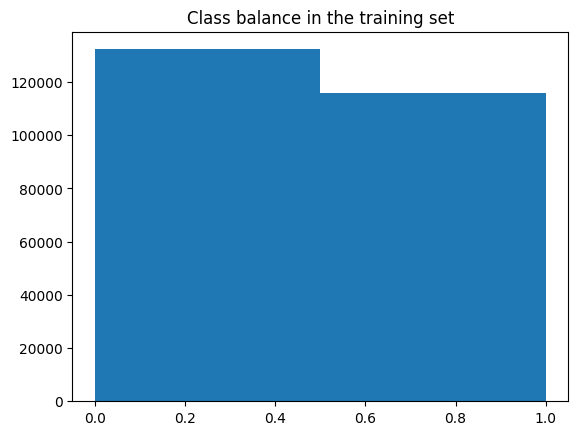

In [11]:
# Class balance in the training set
behaviour = [sample.behaviour[indx_behaviour1] for sample in train_dataset]
behaviour = np.array(behaviour)
print('The class balance in the training set is:')
print(np.unique(behaviour, return_counts=True))

plt.hist(behaviour, bins=2)
plt.title('Class balance in the training set')
plt.show()

#### Augmentation

In [11]:
print('Merging the behaviours')
augmentation.merge_symetric_behaviours_version2(indx_behaviour1, indx_behaviour2, train_dataset)
print('Generating rotation augmentation')
# Rotate the dataset
augmentation.rotate_samples(train_dataset, indx_behaviour1)
#print('Downsampling the inactive behaviours')
#train_dataset = augmentation.downsample_majority_class(train_dataset, indx_behaviour1)
 

Merging the behaviours
Generating rotation augmentation


In [78]:
                                                
for i in range(len(train_dataset)):
    train_dataset[i].behaviour = train_dataset[i].behaviour[indx_behaviour1]
for i in range(len(test_dataset)):
    test_dataset[i].behaviour = test_dataset[i].behaviour[indx_behaviour1]
print('Done selecting the behaviour')


Done selecting the behaviour


In [79]:
print('The train dataset has %d samples' % len(train_dataset))
print('The test dataset has %d samples' % len(test_dataset))


The train dataset has 248061 samples
The test dataset has 62016 samples


The class balance in the training set is:
(array([0, 1], dtype=int64), array([122801, 125260], dtype=int64))


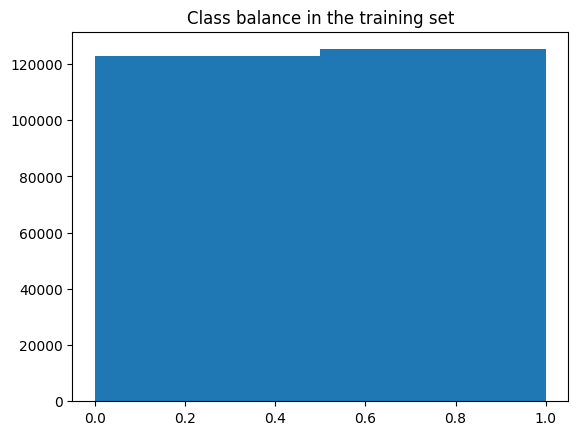

In [48]:
# Class balance in the training set
behaviour = [sample.behaviour for sample in train_dataset]
behaviour = np.array(behaviour)
print('The class balance in the training set is:')
print(np.unique(behaviour, return_counts=True))

plt.hist(behaviour, bins=2)
plt.title('Class balance in the training set')
plt.show()


In [49]:
# Compute weights for the loss function


weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes = np.unique(behaviour), y = behaviour)

In [50]:
print('The weights for the loss function are:')
print(weights)

The weights for the loss function are:
[1.01001213 0.99018442]


In [51]:
batch_size = 32

# Create the dataloaders for train, validation and test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


c:\Users\Usuario\anaconda3\envs\envProj\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


---

### Model definition

In [52]:
importlib.reload(models)

<module 'models' from 'c:\\Users\\Usuario\\Documents\\Documents\\MVA\\Stage\\DLCProject\\Code\\GitHubRep\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [53]:
# Define the model
graphencoder = models.GATEncoder(nout = 64, nhid=32, attention_hidden=2, n_in=4, dropout=0.5)
class_head = models.ClassificationHead(n_latent=64, nhid = 32, nout = 2)


In [54]:
model = models.GraphClassifier(graphencoder, class_head, readout = 'mean')

model.to(device)

print('The model has %d trainable parameters' % sum(p.numel() for p in model.parameters() if p.requires_grad))


The model has 24962 trainable parameters


---

In [55]:
def mean_pooling_per_graph(embbed, batch, frame_mask):
    ''' Mean pooling of the embeddings per graph, only the central frame '''
    out = []
    for i in range(batch.max()+1):
        out.append(embbed[batch==i][frame_mask[batch==i] == frame_mask[batch==i].median()].mean(dim=0))
    return torch.stack(out)



In [56]:
batch_0 = next(iter(train_loader))

In [57]:
batch_0

DataBatch(x=[5760, 4], edge_index=[2, 124416], file=[32], frame_mask=[5760], behaviour=[32], behaviour_names=[32], batch=[5760], ptr=[33])

In [58]:
embed = graphencoder(batch_0.x, batch_0.edge_index, batch_0.edge_attr)

In [59]:
embed.shape

torch.Size([5760, 64])

In [60]:
lat = mean_pooling_per_graph(embed, batch_0.batch, batch_0.frame_mask)

In [61]:
lat.shape

torch.Size([32, 64])

In [62]:
out = class_head(lat)

In [63]:
out.shape

torch.Size([32, 2])

----

### Loop

In [64]:
# Directory to save the model checkpoints
checkpoint_dir = r'./deletefolder/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, loss, path):
    # Save the model, optimizer state, epoch, and loss
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return epoch

In [65]:
# Import f1_score and matthews_corrcoef from sklearn
from sklearn.metrics import f1_score, matthews_corrcoef

In [66]:
num_epochs = 200
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
metric_0 = f1_score
metric_1 = matthews_corrcoef

if True:
    # Training loop
    actual_epoch = 0
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
    

if False:
    # Load the model from a checkpoint
    checkpoint_path = r'/gpfs/users/alvarezj/workdir/Project/Data/Checkpoints/GAT_Sniffin_Anal/checkpoint_epoch_170.pth'
    actual_epoch = load_checkpoint(model, optimizer, checkpoint_path)


In [67]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(device))
writer = SummaryWriter(log_dir='./deletefolder/runs/GAT_Following_w11_new_encoder_2')  # TensorBoard writer


In [68]:
start_time = time.time()  # Time the training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    correct_class_0 = 0
    correct_class_1 = 0
    total_class_0 = 0
    total_class_1 = 0
    total = 0
    i = 0

    for data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        labels = data.behaviour

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        correct_class_0 += (predicted[labels == 0] == labels[labels == 0]).sum().item()
        correct_class_1 += (predicted[labels == 1] == labels[labels == 1]).sum().item()
        total_class_0 += (labels == 0).sum().item()
        total_class_1 += (labels == 1).sum().item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Log training loss and accuracy at each step
        if i % 100 == 0:  # Log every 100 iterations, adjust as needed
            writer.add_scalar('Loss/Train', loss.item(), (actual_epoch + epoch) * len(train_loader) + i)
            writer.add_scalar('Accuracy/Train', correct / total, (actual_epoch + epoch) * len(train_loader) + i)
            # Metrics 
            writer.add_scalar('Metrics/Train/F1', metric_0(labels, predicted), (actual_epoch + epoch) * len(train_loader) + i)
            writer.add_scalar('Metrics/Train/Matthews', metric_1(labels, predicted), (actual_epoch + epoch) * len(train_loader) + i)
        i += 1

    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + actual_epoch + 1}, Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    correct_class_0 = 0
    correct_class_1 = 0
    total_class_0 = 0
    total_class_1 = 0
    total = 0
    with torch.no_grad():
        for val_data in tqdm.tqdm(test_loader):
            val_outputs = model(val_data)
            val_labels = val_data.behaviour
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs.argmax(dim=1)
            correct_class_0 += (val_predicted[val_labels == 0] == val_labels[val_labels == 0]).sum().item()
            correct_class_1 += (val_predicted[val_labels == 1] == val_labels[val_labels == 1]).sum().item()
            total_class_0 += (val_labels == 0).sum().item()
            total_class_1 += (val_labels == 1).sum().item()
            correct += (val_predicted == val_labels).sum().item()
            total += val_labels.size(0)

    val_accuracy = correct / total
    avg_val_loss = val_loss / len(test_loader)

    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

    # Log validation metrics
    writer.add_scalar('Loss/Validation', avg_val_loss, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Avarage_inactive_class_Validation', correct_class_0 / total_class_0, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Avarage_active_class_Validation', correct_class_1 / total_class_1, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Average_per_class_Validation', ((correct_class_0 / total_class_0) + (correct_class_1 / total_class_1)) / 2, actual_epoch + epoch)
    # Metrics
    writer.add_scalar('Metrics/Validation/F1', metric_0(val_labels, val_predicted), actual_epoch + epoch)
    writer.add_scalar('Metrics/Validation/Matthews', metric_1(val_labels, val_predicted), actual_epoch + epoch)

    # Step the scheduler
    #scheduler.step()

    # Log learning rate
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, actual_epoch + epoch)
    print(f"Learning Rate after epoch {epoch + 1}: {current_lr}")

    # Save checkpoint after each 5 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + actual_epoch + 1}.pth')
        save_checkpoint(model, optimizer, epoch + 1, avg_train_loss, checkpoint_path)

# Save the final model
if num_epochs % 5 != 0:
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + actual_epoch + 1}.pth')
    save_checkpoint(model, optimizer, epoch + 1, avg_train_loss, checkpoint_path)

# Time the training
end_time = time.time()
print(f"Training took {end_time - start_time} seconds, for {num_epochs} epochs")
# Close the TensorBoard writer
writer.close()

print("Training finished")

  0%|          | 3/7752 [00:03<2:26:09,  1.13s/it]


KeyboardInterrupt: 

## Benchmark model 

In [116]:
batch = next(iter(train_loader))

x, edge_index, batch, frame_mask = batch.x, batch.edge_index, batch.batch, batch.frame_mask

In [ ]:
frame_mask

In [145]:

model = models.SimpleMLPforGraph(n_in=144, n_hid=128, n_out=2)

# Trainning

In [146]:
# Trainning loop
num_epochs = 10
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir='runs/gcn_action_detection')  # TensorBoard writer


In [ ]:

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for i, data in tqdm.tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        outputs = model(data).unsqueeze(0)
        labels = data.y
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Log training loss and accuracy at each step
        if i % 10 == 0:  # Log every 10 iterations, adjust as needed
            writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + i)
            writer.add_scalar('Accuracy/Train', correct / total, epoch * len(train_loader) + i)
            #print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item()}, Accuracy: {correct / total}")

    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_data in tqdm.tqdm(test_loader):
            val_outputs = model(val_data).unsqueeze(0)
            val_labels = val_data.y
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs.argmax(dim=1)
            correct += (val_predicted == val_labels).sum().item()
            total += val_labels.size(0)
    
    val_accuracy = correct / total
    avg_val_loss = val_loss / len(test_loader)
    
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

    # Log validation metrics
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

# Close the TensorBoard writer
writer.close()


In [ ]:
    for i, data in tqdm.tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        outputs = model(data)
        labels = data.y
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
        # Log training loss and accuracy at each step
        if i % 10 == 0:  # Log every 10 iterations, adjust as needed
            writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + i)
            writer.add_scalar('Accuracy/Train', correct / total, epoch * len(train_loader) + i)
            #print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item()}, Accuracy: {correct / total}")

    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_data in test_loader:
            val_outputs = model(val_data)
            val_labels = val_data.y
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs.argmax(dim=1)
            correct += (val_predicted == val_labels).sum().item()
            total += val_labels.size(0)
    
    val_accuracy = correct / total
    avg_val_loss = val_loss / len(test_loader)
    
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

    # Log validation metrics
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

# Close the TensorBoard writer
writer.close()


# Trainning loop
epochs = 50
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    running_loss = 0.0
    las
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        out = model.forward(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100
        

In [ ]:
out = GraphAE.forward(data_loader.dataset[0].x, data_loader.dataset[0].edge_index, data_loader.dataset[0].frame_mask)

In [ ]:
# Loss and optimizer
loss = GraphAE.loss(data_loader.dataset[0].x, out)

In [ ]:
print(loss)

# Trainning loop

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
encoder = models.GATEncoder(nout = 64, nhid=16, attention_hidden=2, n_in=3, dropout=0.5).to(device)
print(encoder)
decoder = models.GATDecoder(n_latent=64, n_hidden=16, n_out=3).to(device)
print(decoder)
model = models.GraphAE(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
data = data_loader.dataset

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    for i in range(len(data)):

        out = model(data[i].x.to(device), data[i].edge_index.to(device), data[i].frame_mask.to(device))
        loss = model.loss(data[i].x, out)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {loss.item()}')

model.eval()
out = model(data[0].x, data[0].edge_index, data[0].frame_mask)

In [ ]:
print(out[0][0].shape)

In [ ]:
numpyout = out[0][0].detach().numpy()

In [ ]:
# Plot the output of the model, the first dimension are the points, and the second one is the x and y coordinates
plt.scatter(numpyout[:,0], numpyout[:,1])


In [ ]:
print(data_loader.dataset[0].x.shape)
print(x[0].shape)
print(x[1].shape)

In [ ]:
print(data_loader.dataset[0].x.shape)
print(x[0].shape)
print(x[1].shape)

In [ ]:
contacts = behaviour.iloc[:,1]

---